# [如何将CNN用于时间序列](https://machinelearningmastery.com/how-to-develop-convolutional-neural-networks-for-multi-step-time-series-forecasting/)

我们将会研究以下三种模型：
+ 单变量CNN(Univariate CNN)预测多步时间序列
+ 多通道CNN(Multichannel CNN)预测多步时间序列
+ 多头CNN(Multihead CNN)预测多步时间序列

## 数据描述

Household Power Consumption数据集是一个多变量时间序列数据集，用于描述单个家庭4年的用电量，收集了2006年12月至2010年11月的数据。

原数据是分钟级数据，我们预先对数据进行处理，对于空值我们用24小时前的同意数据进行替代，将分钟级数据加和得到日级数据。

数据由7个变量组成（除日期和时间外），分别为：

+ global_active_power：家庭消耗的总有功功率（千瓦）。
+ global_reactive_power：家庭消耗的总无功功率（千瓦）。
+ voltage：平均电压（伏特）。
+ global_intensity：平均电流强度（安培）。
+ sub_metering_1：厨房的有功电能（瓦时）。
+ sub_metering_2：用于洗衣的有功能量（瓦时）。
+ sub_metering_3：气候控制系统的有功电能（瓦时）。

可以通过从总有功耗电量中减去三个部分耗电量的和来构建剩余耗电量，如下所示：

sub_metering_remainder = (global_active_power * 1000 / 60) - (sub_metering_1 + sub_metering_2 + sub_metering_3)

4年数据中，我们取前3年数据作为训练集（共159周），取最后1年作为测试集（共46周）。

In [20]:
read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime']).head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


## 问题描述与模型评估

我们考虑的问题是：

**“鉴于最近的耗电量，未来一周的预期耗电量是多少？”**

即使用历史数据预测未来七天每天的总有功功率。

由于需要预测多步，因此这个问题的框架被称为**多步时间序列预测**问题。利用多个输入变量的模型可以称为**多变量多步时间序列预测模型**。

CNN除了可以输入一个1D数据(Univariate)进行预测，还可以输入多个1D输入以进行预测，如：
+ 多输入通道(Multiple Input Channels)。每个输入序列作为单独的通道读取，如图像的不同通道（例如红色、绿色和蓝色）。
+ 多输入头(Multiple Input Heads)。每个输入序列由不同的CNN子模型读取，然后进行组合预测。

我们将使用未来一周每天的均方根误差(RMSE)作为评价指标，构建`evaluate_forecasts()`函数，评价模型性能。我们后面将以一个RMSE为465千瓦的简单模型进行比较。

In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

## 模型一：单变量CNN(Univariate CNN)预测多步时间序列

单变量CNN(Univariate CNN)期望数据具有以下形状：

[sample, timesteps, features]

一个样本将包含7天，我们共有159个标准周的数据，然而159个数据作为训练集并不够用。因此我们可以通过滚动时间来增加训练样本，每次滚动1天，并预测随后7天的时间序列。

例如：

|Input|Output|
|:---:|:---:|
|[d01, d02, d03, d04, d05, d06, d07]|[d08, d09, d10, d11, d12, d13, d14]|
|[d02, d03, d04, d05, d06, d07, d08]|[d09, d10, d11, d12, d13, d14, d15]|
|...|...|

我们可以通过构建`to_supervised()`函数来实现：

In [ ]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

当我们在整个训练数据集上运行此函数时，我们将159个样本转换为1,099个; 具体地，变换的数据集具有形状X = [1099,7,1]和y = [1099,7]。

下面我们构建`build_model()`来构建单变量CNN：


In [ ]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
    # verbose为日志显示
    # verbose = 0 为不在标准输出流输出日志信息
    # 20个epochs，批量大小维4
	verbose, epochs, batch_size = 0, 20, 4 
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
    # Sequential是多个网络层的线性堆叠，也就是“一条路走到黑”。
	model = Sequential()
    # 16个filter,核大小为3，1维卷积，ReLu激活层，padding默认为valid，步幅默认为1
    # [?, 7, 1]
	model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    # 最大池化
    # [?, 5, 16]
	model.add(MaxPooling1D(pool_size=2))
    # [?, 2, 16]
	model.add(Flatten())
    # [?, 2*16]
    # 全连接层
	model.add(Dense(10, activation='relu'))
    # [?, 10]
	model.add(Dense(n_outputs))
    # [?, 1]
    # 损失函数用均方误差
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

我们可以将所有这些结合在一起，下面列出了完整的代码：

cnn: [398.269] 437.0, 397.4, 345.3, 382.3, 402.8, 316.4, 483.4


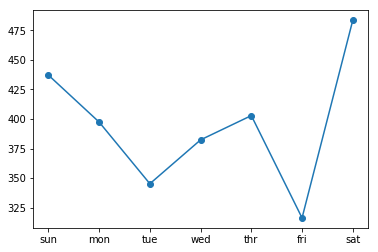

In [15]:
# univariate multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
# 将日数据划分为训练集和测试集，并按周分组
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
# 计算RMSE评价模型
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
# 输出模型RMSE
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
# 扩展训练集
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
# 搭建模型
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 4
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(10, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
# 预测
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
# 得到训练集的RMSE
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

我们可以看到，模型一与简单的预测相比更优的，实现了大约398千瓦的总体RMSE，小于465千瓦的简单模型。

同时我们还画出了每日RMSE的图。该图显示，周二和周五可能比其他日子更容易预测，周六也许是最难预测的日子。

我们还可以将`n_input`从7改为14：

cnn: [393.927] 404.7, 430.4, 352.8, 366.9, 397.8, 380.7, 418.3


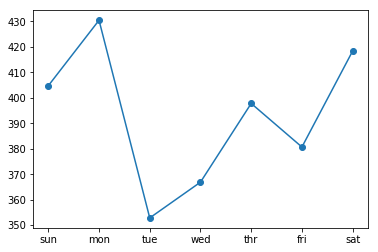

In [14]:
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

我们可以看到整体RMSE进一步下降，这表明进一步调整`n_input`以及模型的filter核大小可能会带来更好的性能。

比较每日RMSE，我们看到有些日子更好，有些比之前更差。

我们建议以某种方式使用两个不同大小`n_input`，可以优化模型，例如两种方法的集合或者可能是以不同方式读取训练数据的单个模型（例如，多头模型）。

## 多通道CNN(Multichannel CNN)预测多步时间序列

在本节中，我们将更新上一节中开发的CNN模型，以使用8个变量中来预测下一周的每日总功耗(global_active_power)。

我们将通过将每个一维时间序列作为**单独的输入通道**进行输入。我们输入的数据形状变为[sample, timesteps, 8]

当预测序列是过去时间序列变量的函数时，该模型将非常有效。目前还不清楚功耗问题是否属于这种情况，但我们仍可以探索它。

首先，我们必须更新训练数据的准备，以包括所有八个变量，而不仅仅是每日消耗这一变量，需要我们修改：

In [ ]:
X.append(data[in_start:in_end, :])

我们修改后的`to_supervised()`函数为：

In [ ]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
            # 使用所有的8个变量作为输入
			X.append(data[in_start:in_end, :])
            # 我们仍然只预测每日总功耗(global_active_power)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

我们还需要修改`forcast()`函数，以使用过去时间中的8个变量，我们修改以下代码：

In [ ]:
# retrieve last observations for input data
input_x = data[-n_input:, :]
# reshape into [1, n_input, features]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))

下面列出更改后的`forcast()`函数：

In [ ]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

同时，我们将使用先前使模型性能更好的 n_input = 14

In [ ]:
n_input = 14

最后，上一节中使用的模型在这个问题的新框架上表现不佳。

这是由于数据量的增加需要更大，更复杂的模型，这种模型需要更长时间的训练。

通过简单试错法，一个表现良好的模型：使用两个带32个filter的卷积层，进行最大池化后，输入到具有16个filter的卷积层，再进行最大池化，最后经过具有100个节点的全连接层。我们采用70个epochs，批量大小取16。

下面列出更新后`build_model()`函数：

In [ ]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
    # [?, 14, 8]
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    # [?, 12, 32]
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    # [?, 10, 32]
	model.add(MaxPooling1D(pool_size=2))
    # [?, 5, 32]
	model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    # [?, 2, 16]
	model.add(MaxPooling1D(pool_size=2))
    # [?, 1, 16]
	model.add(Flatten())
    # [?, 16]
	model.add(Dense(100, activation='relu'))
    # [?, 100]
	model.add(Dense(n_outputs))
    # [?, 1]
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

我们可以得到完整的代码为：

cnn: [385.099] 394.4, 371.2, 339.6, 384.8, 353.1, 306.5, 512.6


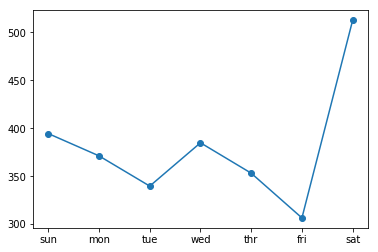

In [17]:
# multichannel multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

我们可以看到，在这种情况下，使用所有八个输入变量确实导致整体RMSE分数小幅下降。

对于每日RMSE分数，我们可以看到一些更好，一些比上一节中的单变量CNN更差。

最后一天，周六，仍然是难以预测的一天，周五则是容易的预测的一天。

## 多头CNN(Multihead CNN)预测多步时间序列

我们可以进一步扩展CNN模型，为每个输入变量设置一个**单独的子CNN模型或头部**，我们可以将其称为多头CNN模型。

从模型开始，我们必须为8个输入变量中的每一个定义一个单独的CNN模型。

模型的配置（包括层数及其超参数）也进行了修改，以更好地适应新方法。新配置不是最佳配置，只需稍加试错即可找到。

我们可以遍历每个变量并创建一个子模型，该子模型采用14天数据的一维序列，并输出包含序列中学习特征摘要的平面向量。这些向量中的每一个可以通过串联产生一个非常长的向量，然后接入到全连接层。

我们需要构建8个子模型：

In [ ]:
# create a channel for each variable
in_layers, out_layers = list(), list()
for i in range(n_features):
	inputs = Input(shape=(n_timesteps,1))
    # [?, 14, 1]
	conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
    # [?, 12, 32]
	conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
    # [?, 10, 32]
	pool1 = MaxPooling1D(pool_size=2)(conv2)
    # [?, 5, 32]
	flat = Flatten()(pool1)
    # [?, 5*32]
	# store layers
	in_layers.append(inputs)
	out_layers.append(flat)
# merge heads
merged = concatenate(out_layers)
# [?, 5*32*8]
# interpretation
dense1 = Dense(200, activation='relu')(merged)
# [?, 200]
dense2 = Dense(100, activation='relu')(dense1)
# [?, 100]
outputs = Dense(n_outputs)(dense2)
# [?, 1]
model = Model(inputs=in_layers, outputs=outputs)
# compile model
model.compile(loss='mse', optimizer='adam')

使用该模型时，它将需要8个数组作为输入,每个子模型1个。

在训练模型，评估模型以及使用最终模型进行预测时，这是必需的。

我们可以通过创建3D数组列表来实现这一点，其中每个3D数组包含[samples, timesteps, 1]，具有一个功能。

我们可以按以下格式准备训练数据集：

In [ ]:
input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]

更新后的`build_model()`函数为：

In [ ]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 25, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# create a channel for each variable
	in_layers, out_layers = list(), list()
	for i in range(n_features):
		inputs = Input(shape=(n_timesteps,1))
		conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
		conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
		pool1 = MaxPooling1D(pool_size=2)(conv2)
		flat = Flatten()(pool1)
		# store layers
		in_layers.append(inputs)
		out_layers.append(flat)
	# merge heads
	merged = concatenate(out_layers)
	# interpretation
	dense1 = Dense(200, activation='relu')(merged)
	dense2 = Dense(100, activation='relu')(dense1)
	outputs = Dense(n_outputs)(dense2)
	model = Model(inputs=in_layers, outputs=outputs)
	# compile model
	model.compile(loss='mse', optimizer='adam')
	# plot the model
	plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
	# fit network
	input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
	model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

模型的结构如下图：

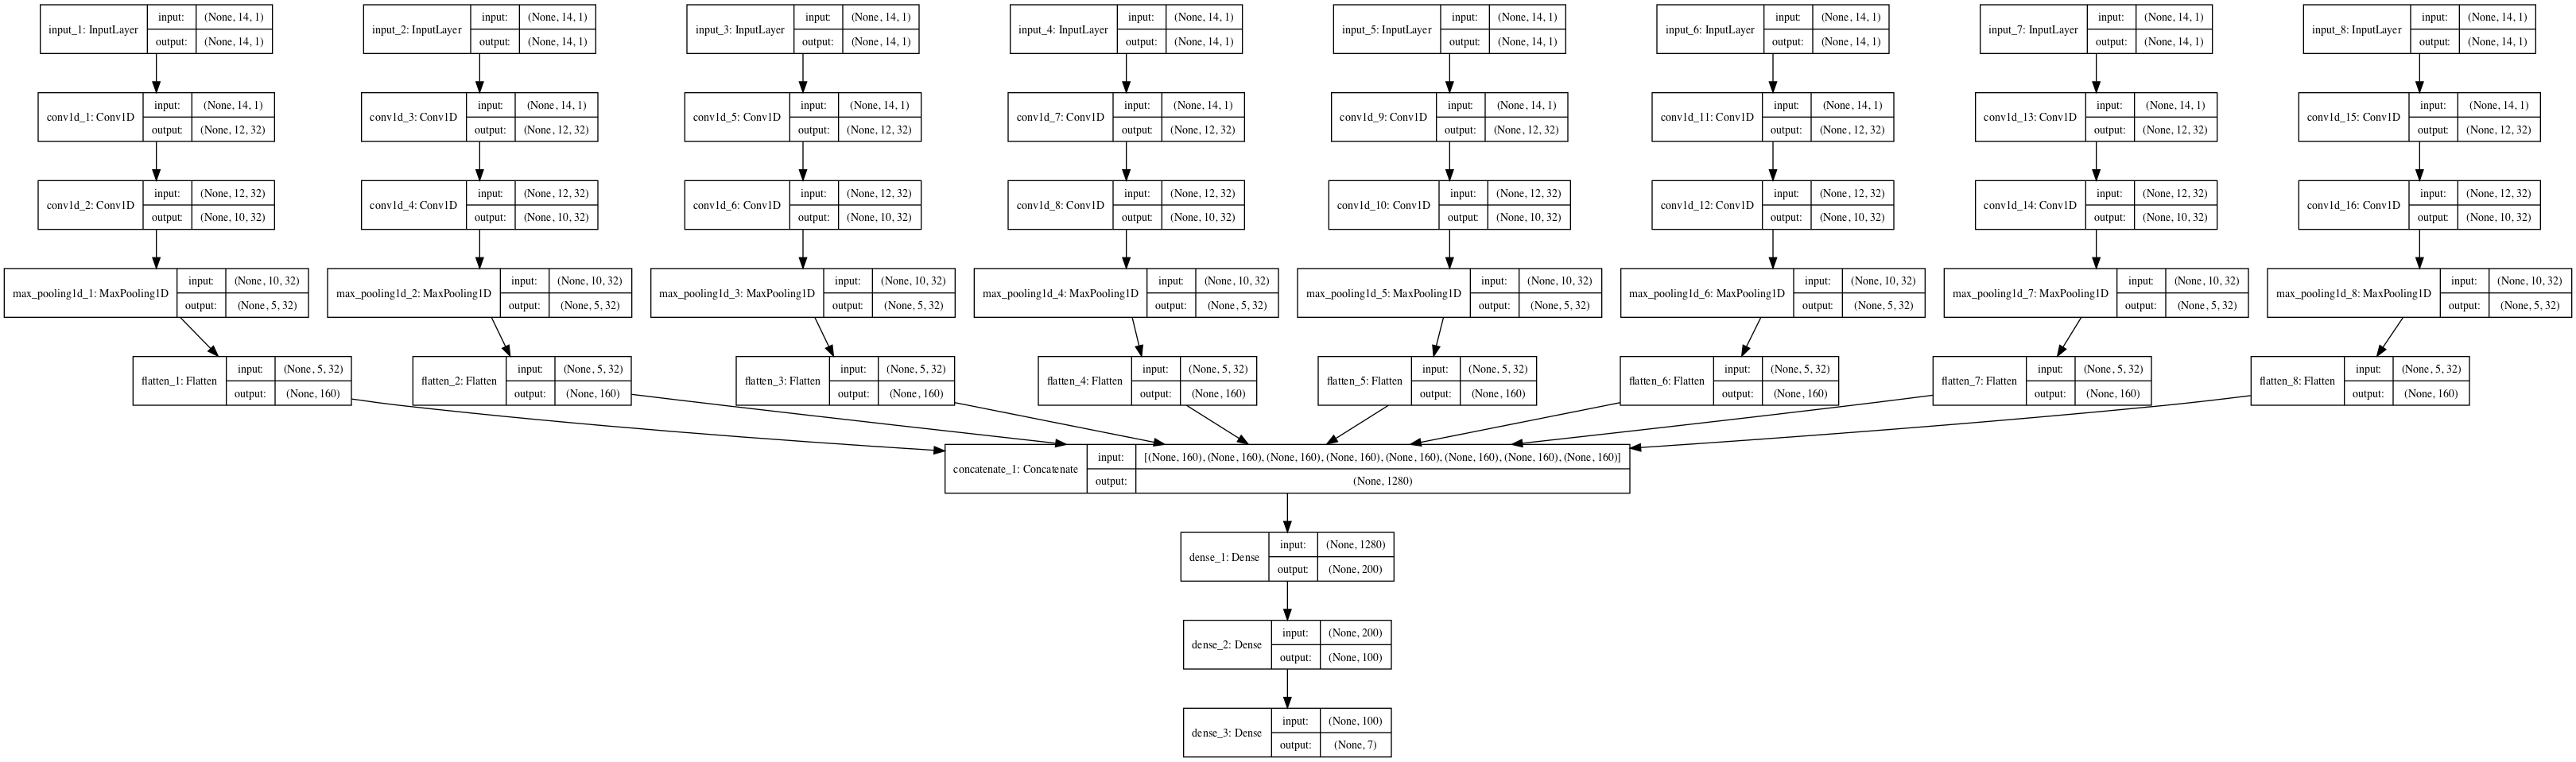

我们对`forcast()`函数的输入数据进行同样地修改，修改后的`forcast()`函数：

In [ ]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into n input arrays
    # 修改预测输入数据结构
	input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

我们可以将所有这些结合在一起，并给出完整的示例：

cnn: [395.307] 428.2, 398.2, 395.1, 388.6, 364.0, 322.3, 456.6


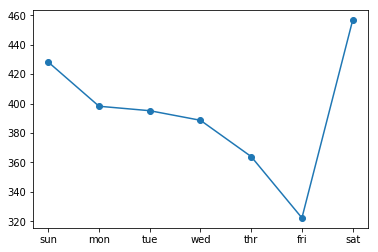

In [19]:
# multi headed multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# plot training history
def plot_history(history):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(history.history['loss'], label='train')
	pyplot.plot(history.history['val_loss'], label='test')
	pyplot.title('loss', y=0, loc='center')
	pyplot.legend()
	# plot rmse
	pyplot.subplot(2, 1, 2)
	pyplot.plot(history.history['rmse'], label='train')
	pyplot.plot(history.history['val_rmse'], label='test')
	pyplot.title('rmse', y=0, loc='center')
	pyplot.legend()
	pyplot.show()

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 25, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# create a channel for each variable
	in_layers, out_layers = list(), list()
	for i in range(n_features):
		inputs = Input(shape=(n_timesteps,1))
		conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
		conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
		pool1 = MaxPooling1D(pool_size=2)(conv2)
		flat = Flatten()(pool1)
		# store layers
		in_layers.append(inputs)
		out_layers.append(flat)
	# merge heads
	merged = concatenate(out_layers)
	# interpretation
	dense1 = Dense(200, activation='relu')(merged)
	dense2 = Dense(100, activation='relu')(dense1)
	outputs = Dense(n_outputs)(dense2)
	model = Model(inputs=in_layers, outputs=outputs)
	# compile model
	model.compile(loss='mse', optimizer='adam')
	# fit network
	input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
	model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into n input arrays
	input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

我们可以看到，在这种情况下，与简单预测相比，整体RMSE更优，但是所选择的配置可能不会比上一节中的多通道模型表现更好。

我们还可以看到每日RMSE分数的不同，周五相对容易预测，而周六较难预测。

## 扩展

+ **输入时间长短。**探索用作模型输入更多的天数或更少的天数，例如3天，21天，30天等。
+ **模型调整。**调整模型的结构和超参数，并进一步平均提升模型性能。
+ **数据标准化。**探索数据标准化是否可用于改善CNN模型的性能。
+ **诊断曲线。**使用诊断，例如诊断训练集、验证集的损失函数曲线，以帮助调整CNN模型的结构和超参数。
+ **改变filter核大小。**将多通道CNN与多头CNN结合使用，并为每个子模型使用不同的filter核大小，以观察是否可以进一步提高性能。